# Machine learning challenges for genomics

In [2]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import lime
import lime.lime_tabular
import numpy as np

## Read Data

In [3]:
path = 'data/samples/'
samples = []
for f in glob.glob(path+'*.csv'):
    data = pd.read_csv(f)
    samples.append(data)

In [5]:
samples[0].head()

Unnamed: 0 ALT  HG00096
0   5;195139   T        0
1   5;336952   C        1
2   5;389603   C        1
3   5;851582   A        1
4  5;1144802   C        0

Joining the patient id column to the first DataFrame iteratively over samples

In [6]:
data = samples[0][["Unnamed: 0", "ALT"]]
for df in samples:
    data[df.columns[2]] = df[df.columns[2]]

In [7]:
data.head()

Unnamed: 0 ALT  HG00096  HG00097  HG00099  HG00100  HG00101  HG00102  \
0   5;195139   T        0        0        0        0        0        0   
1   5;336952   C        1        1        1        1        0        0   
2   5;389603   C        1        1        0        0        0        1   
3   5;851582   A        1        1        1        0        0        0   
4  5;1144802   C        0        1        1        1        1        1   

   HG00103  HG00105  ...  NA21128  NA21129  NA21130  NA21133  NA21135  \
0        0        0  ...        0        0        0        0        0   
1        1        1  ...        1        1        1        1        1   
2        1        0  ...        0        0        0        1        0   
3        0        1  ...        0        0        0        1        1   
4        0        1  ...        1        1        1        1        1   

   NA21137  NA21141  NA21142  NA21143  NA21144  
0        0        0        0        0        0  
1        1        1        0        0        0  
2        0        0        0        1        0  
3        0        0        1        0        0  
4        1        1        1        1        1  

[5 rows x 2506 columns]

Creating a header column for further use

In [8]:
data['header'] = data['Unnamed: 0'] + ';' + data['ALT']

Rotating the data DataFrame so that we can have a data set with the correct dimensions to train a model

In [9]:
data = data.T

In [10]:
data = data.rename(columns=data.loc['header'])
data = data.drop(labels = 'header', axis = 0)
data = data.drop(labels = 'Unnamed: 0', axis = 0) 
data = data.drop(labels = 'ALT', axis = 0)

In [11]:
data.head()

5;195139;T 5;336952;C 5;389603;C 5;851582;A 5;1144802;C 5;1167618;C  \
HG00096          0          1          1          1           0           0   
HG00097          0          1          1          1           1           0   
HG00099          0          1          0          1           1           0   
HG00100          0          1          0          0           1           0   
HG00101          0          0          0          0           1           0   

        5;1175892;G 5;1398007;T 5;1447860;T 5;1721485;C  ... 22;49335230;T  \
HG00096           0           0           1           1  ...             1   
HG00097           0           0           1           1  ...             0   
HG00099           0           0           1           1  ...             1   
HG00100           0           1           1           1  ...             1   
HG00101           0           0           1           1  ...             0   

        22;49363742;A 22;49578486;T 22;49651708;A 22;49666841;G 22;49797810;A  \
HG00096             0             0             1             1             1   
HG00097             0             0             1             1             0   
HG00099             0             0             0             1             0   
HG00100             0             0             0             1             1   
HG00101             0             0             1             1             0   

        22;49855674;G 22;50021013;A 22;50258751;A 22;50458664;C  
HG00096             1             0             1             0  
HG00097             1             0             1             0  
HG00099             1             0             1             0  
HG00100             1             0             1             0  
HG00101             1             0             1             0  

[5 rows x 10028 columns]

Getting the target/labels data from ancestry file

In [12]:
ancestry = pd.read_csv('data/ancestry.tsv', sep = '\t')
ancestry_labels = ancestry[['Sample name','Superpopulation code']]

In [13]:
ancestry_labels = ancestry_labels.set_index(ancestry_labels['Sample name'])
ancestry_labels = ancestry_labels.drop(labels = 'Sample name', axis = 1)

In [14]:
ancestry_labels.head()

Superpopulation code
Sample name                     
NA19625                      AFR
NA19835                      AFR
NA19900                      AFR
NA19917                      AFR
NA19703                      AFR

Adding labels to data by merging ancestry label and data DataFrames

In [15]:
data = data.join(ancestry_labels)

In [16]:
data.head()

5;195139;T 5;336952;C 5;389603;C 5;851582;A 5;1144802;C 5;1167618;C  \
HG00096          0          1          1          1           0           0   
HG00097          0          1          1          1           1           0   
HG00099          0          1          0          1           1           0   
HG00100          0          1          0          0           1           0   
HG00101          0          0          0          0           1           0   

        5;1175892;G 5;1398007;T 5;1447860;T 5;1721485;C  ... 22;49363742;A  \
HG00096           0           0           1           1  ...             0   
HG00097           0           0           1           1  ...             0   
HG00099           0           0           1           1  ...             0   
HG00100           0           1           1           1  ...             0   
HG00101           0           0           1           1  ...             0   

        22;49578486;T 22;49651708;A 22;49666841;G 22;49797810;A 22;49855674;G  \
HG00096             0             1             1             1             1   
HG00097             0             1             1             0             1   
HG00099             0             0             1             0             1   
HG00100             0             0             1             1             1   
HG00101             0             1             1             0             1   

        22;50021013;A 22;50258751;A 22;50458664;C Superpopulation code  
HG00096             0             1             0                  EUR  
HG00097             0             1             0                  EUR  
HG00099             0             1             0                  EUR  
HG00100             0             1             0                  EUR  
HG00101             0             1             0                  EUR  

[5 rows x 10029 columns]

In [13]:
data['Superpopulation code'].unique()

array(['EUR', 'EAS', 'AMR', 'SAS', 'AFR'], dtype=object)

Some of the ancestry labels are not grouped together and they should be like: "European Ancestry" and "European Ancestry, West Eurasia (SGDP)". I want to group them so that I end up with 4 main categories, corresponding to each continent mentioned in the labels.

In [16]:
# labels = []
# for l in data['Superpopulation name']:
#     if 'African' in l:
#         labels.append('African')
#     elif 'European' in l:
#         labels.append('European')
#     elif 'American' in l:
#         labels.append('American')
#     elif 'Asian' in l:
#         labels.append('Asian')

In [17]:
# data['Superpopulation code'] = labels

In [18]:
# data['Superpopulation name'].unique()

array(['European', 'Asian', 'American', 'African'], dtype=object)

The model will be trainned separately as binary classification for each class. So, as it won't be a multiclass classifier, I need to process the labels column ("Superpopulation code") to make 5 columns (one for each class) so I can train with each one of them

In [17]:
labels = pd.get_dummies(data['Superpopulation code'])

In [18]:
labels.head()

AFR  AMR  EAS  EUR  SAS
HG00096    0    0    0    1    0
HG00097    0    0    0    1    0
HG00099    0    0    0    1    0
HG00100    0    0    0    1    0
HG00101    0    0    0    1    0

In [19]:
#We don't need this column anymore
original_labels = data['Superpopulation code']
data = data.drop(labels = 'Superpopulation code', axis = 1)

In [20]:
# labels.to_csv('labels.csv')

In [23]:
# data.to_csv('data.csv')

## Exploratory data analysis

First I want to check if there are any null or missing values in our data

In [23]:
data.isnull().values.any()

False

In [24]:
labels.isnull().values.any()

False

Now I want to check the datatype of the DataFrames

In [25]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2504 entries, HG00096 to NA21144
Data columns (total 10028 columns):
 #      Column           Dtype 
---     ------           ----- 
 0      5;195139;T       object
 1      5;336952;C       object
 2      5;389603;C       object
 3      5;851582;A       object
 4      5;1144802;C      object
 5      5;1167618;C      object
 6      5;1175892;G      object
 7      5;1398007;T      object
 8      5;1447860;T      object
 9      5;1721485;C      object
 10     5;1775600;G      object
 11     5;1942377;A      object
 12     5;2003180;A      object
 13     5;2018426;T      object
 14     5;2692076;G      object
 15     5;2703314;T      object
 16     5;2843763;C      object
 17     5;2985474;A      object
 18     5;3190290;A      object
 19     5;3203172;G      object
 20     5;3301209;G      object
 21     5;3337359;C      object
 22     5;3360109;C      object
 23     5;3429915;A      object
 24     5;3510624;T      object
 25     5;3539652;T   

In [26]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2504 entries, HG00096 to NA21144
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   African   2504 non-null   uint8
 1   American  2504 non-null   uint8
 2   Asian     2504 non-null   uint8
 3   European  2504 non-null   uint8
dtypes: uint8(4)
memory usage: 93.9+ KB


We can see that the data DataFrame has object type data and we want it to be integers so that it can be read by our model, so we need to cast the values in the DataFrame

In [21]:
data = data.apply(pd.to_numeric)

In [28]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2504 entries, HG00096 to NA21144
Data columns (total 10028 columns):
 #      Column           Dtype
---     ------           -----
 0      5;195139;T       int64
 1      5;336952;C       int64
 2      5;389603;C       int64
 3      5;851582;A       int64
 4      5;1144802;C      int64
 5      5;1167618;C      int64
 6      5;1175892;G      int64
 7      5;1398007;T      int64
 8      5;1447860;T      int64
 9      5;1721485;C      int64
 10     5;1775600;G      int64
 11     5;1942377;A      int64
 12     5;2003180;A      int64
 13     5;2018426;T      int64
 14     5;2692076;G      int64
 15     5;2703314;T      int64
 16     5;2843763;C      int64
 17     5;2985474;A      int64
 18     5;3190290;A      int64
 19     5;3203172;G      int64
 20     5;3301209;G      int64
 21     5;3337359;C      int64
 22     5;3360109;C      int64
 23     5;3429915;A      int64
 24     5;3510624;T      int64
 25     5;3539652;T      int64
 26     5;3659989;

At this point I think it would be important to check the distribution of our data just to have some insights about the data we will we working on

<AxesSubplot:xlabel='Superpopulation code', ylabel='count'>

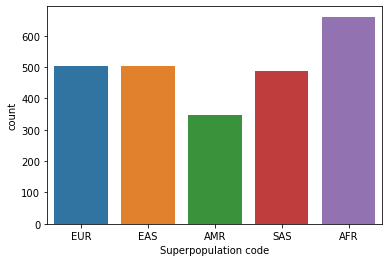

In [29]:
sns.countplot(x = original_labels)

## Model training

Firs I need to split the data into traing and test set with a 80/20 ratio

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

### African ancestry model

Now I'll proceed to train the classifier using a Support Vector Machine model

In [31]:
model = svm.SVC()

In order to choose the best parameters for the model I will perform a grid search

In [35]:
parameters = {'C': [0.6, 0.8, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : [2,3,4,5,6]}
clf = GridSearchCV(model, parameters, cv = 5, verbose = 1, scoring='roc_auc')

In [36]:
clf.fit(X_train, y_train['AFR'])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.6, 0.8, 1, 1.2], 'degree': [2, 3, 4, 5, 6],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc', verbose=1)

In [37]:
results = pd.DataFrame(clf.cv_results_)
results[results['rank_test_score'] == 1].sort_values(by=['mean_fit_time'], ascending=True)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
11       5.260601      0.183348         1.276000        0.151291     0.6   
7        5.545185      0.245864         1.320725        0.111022     0.6   
15       5.556197      0.218472         1.331807        0.103699     0.6   
19       5.655939      0.207541         1.337840        0.074469     0.6   
3        5.703092      0.231186         1.442635        0.087566     0.6   

   param_degree param_kernel                                        params  \
11            4      sigmoid  {'C': 0.6, 'degree': 4, 'kernel': 'sigmoid'}   
7             3      sigmoid  {'C': 0.6, 'degree': 3, 'kernel': 'sigmoid'}   
15            5      sigmoid  {'C': 0.6, 'degree': 5, 'kernel': 'sigmoid'}   
19            6      sigmoid  {'C': 0.6, 'degree': 6, 'kernel': 'sigmoid'}   
3             2      sigmoid  {'C': 0.6, 'degree': 2, 'kernel': 'sigmoid'}   

    split0_test_score  split1_test_score  split2_test_score  \
11           0.990894                1.0                1.0   
7            0.990894                1.0                1.0   
15           0.990894                1.0                1.0   
19           0.990894                1.0                1.0   
3            0.990894                1.0                1.0   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
11           0.999968                1.0         0.998172        0.003639   
7            0.999968                1.0         0.998172        0.003639   
15           0.999968                1.0         0.998172        0.003639   
19           0.999968                1.0         0.998172        0.003639   
3            0.999968                1.0         0.998172        0.003639   

    rank_test_score  
11                1  
7                 1  
15                1  
19                1  
3                 1

Now I will intialize the model with the parameters that gave the best results

In [54]:
model = svm.SVC(C = 0.6, kernel = 'sigmoid', probability = True)

In order to evaluate the model, I was asked to perfom a 10-fold cross validation

In [44]:
score = cross_val_score(model, X_train, y_train['AFR'], scoring="roc_auc", cv = 10)

In [45]:
score.mean(), score.std()

(0.9981642019377869, 0.005507394186639469)

We can infer from the score that the model is performing well enough in the mayority of the cases. So now I'll fit the whole training data and evaluate on the test set.

In [55]:
model.fit(X_train, y_train['AFR'])

SVC(C=0.6, kernel='sigmoid', probability=True)

In [56]:
predictions = model.predict(X_test)

In [57]:
roc_auc_score(y_test['AFR'], predictions)

0.9949767385898773

In [58]:
feature_names = data.columns
class_names=[0,1]
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [59]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_np, mode = 'classification', feature_names=feature_names, class_names=class_names)

In [60]:
exp = explainer.explain_instance(X_test_np[21], model.predict_proba, num_features=5, top_labels=1)

In [61]:
exp.show_in_notebook(show_table=True, show_all=False)

In [62]:
exp.save_to_file("classif_african.html")

In [70]:
model.predict([X_test.iloc[21]])

array([1], dtype=uint8)

### South Asian ancestry model

In [34]:
model = svm.SVC()

In [35]:
parameters = {'C': [0.6, 0.8, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : [2,3,4,5,6]}
clf = GridSearchCV(model, parameters, cv = 5, verbose = 1, scoring='roc_auc')

In [36]:
clf.fit(X_train, y_train['SAS'])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.6, 0.8, 1, 1.2], 'degree': [2, 3, 4, 5, 6],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc', verbose=1)

In [37]:
results = pd.DataFrame(clf.cv_results_)
results[results['rank_test_score'] == 1].sort_values(by=['mean_fit_time'], ascending=True).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
71       3.959651      0.078170         0.977596        0.013896     1.2   
59       4.233196      0.037304         1.106000        0.132574       1   
67       4.347015      0.734911         1.072003        0.198082     1.2   
63       4.385430      0.894150         0.969397        0.012755     1.2   
75       4.716832      1.190625         1.258297        0.343745     1.2   

   param_degree param_kernel                                        params  \
71            4      sigmoid  {'C': 1.2, 'degree': 4, 'kernel': 'sigmoid'}   
59            6      sigmoid    {'C': 1, 'degree': 6, 'kernel': 'sigmoid'}   
67            3      sigmoid  {'C': 1.2, 'degree': 3, 'kernel': 'sigmoid'}   
63            2      sigmoid  {'C': 1.2, 'degree': 2, 'kernel': 'sigmoid'}   
75            5      sigmoid  {'C': 1.2, 'degree': 5, 'kernel': 'sigmoid'}   

    split0_test_score  split1_test_score  split2_test_score  \
71                1.0                1.0                1.0   
59                1.0                1.0                1.0   
67                1.0                1.0                1.0   
63                1.0                1.0                1.0   
75                1.0                1.0                1.0   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
71                1.0                1.0              1.0             0.0   
59                1.0                1.0              1.0             0.0   
67                1.0                1.0              1.0             0.0   
63                1.0                1.0              1.0             0.0   
75                1.0                1.0              1.0             0.0   

    rank_test_score  
71                1  
59                1  
67                1  
63                1  
75                1

In [38]:
model = svm.SVC(C = 1.2, kernel = 'sigmoid' , probability = True)

In [40]:
score = cross_val_score(model, X_train, y_train['SAS'], scoring="roc_auc", cv = 10)

In [41]:
score.mean(), score.std()

(1.0, 0.0)

In [42]:
model.fit(X_train, y_train['SAS'])

SVC(C=1.2, kernel='sigmoid', probability=True)

In [43]:
predictions = model.predict(X_test)

In [45]:
roc_auc_score(y_test['SAS'], predictions)

1.0

In [46]:
feature_names = data.columns
class_names=[0,1]
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [47]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_np, mode = 'classification', feature_names=feature_names, class_names=class_names)

In [48]:
exp = explainer.explain_instance(X_test_np[21], model.predict_proba, num_features=5, top_labels=1)

In [49]:
exp.show_in_notebook(show_table=True, show_all=False)

In [50]:
exp.save_to_file("classif_asian.html")

In [51]:
model.predict([X_test.iloc[21]])

array([0], dtype=uint8)

### East Asian Ancestry model

In [19]:
model = svm.SVC()

In [53]:
parameters = {'C': [0.6, 0.8, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : [2,3,4,5,6]}
clf = GridSearchCV(model, parameters, cv = 5, verbose = 1, scoring='roc_auc')

In [54]:
clf.fit(X_train, y_train['EAS'])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.6, 0.8, 1, 1.2], 'degree': [2, 3, 4, 5, 6],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc', verbose=1)

In [55]:
results = pd.DataFrame(clf.cv_results_)
results[results['rank_test_score'] == 1].sort_values(by=['mean_fit_time'], ascending=True).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
64       2.769891      0.036193         0.696402        0.006281     1.2   
20       2.814473      0.037776         0.699470        0.010395     0.8   
63       2.974390      0.601575         0.735733        0.237243     1.2   
0        3.218987      0.297242         0.765333        0.049917     0.6   
59       3.256175      0.504738         0.927583        0.161073       1   

   param_degree param_kernel                                        params  \
64            3       linear   {'C': 1.2, 'degree': 3, 'kernel': 'linear'}   
20            2       linear   {'C': 0.8, 'degree': 2, 'kernel': 'linear'}   
63            2      sigmoid  {'C': 1.2, 'degree': 2, 'kernel': 'sigmoid'}   
0             2       linear   {'C': 0.6, 'degree': 2, 'kernel': 'linear'}   
59            6      sigmoid    {'C': 1, 'degree': 6, 'kernel': 'sigmoid'}   

    split0_test_score  split1_test_score  split2_test_score  \
64                1.0                1.0                1.0   
20                1.0                1.0                1.0   
63                1.0                1.0                1.0   
0                 1.0                1.0                1.0   
59                1.0                1.0                1.0   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
64                1.0                1.0              1.0             0.0   
20                1.0                1.0              1.0             0.0   
63                1.0                1.0              1.0             0.0   
0                 1.0                1.0              1.0             0.0   
59                1.0                1.0              1.0             0.0   

    rank_test_score  
64                1  
20                1  
63                1  
0                 1  
59                1

In [20]:
model = svm.SVC(C = 1.2, kernel = 'linear' , probability = True)

In [21]:
score = cross_val_score(model, X_train, y_train['EAS'], scoring="roc_auc", cv = 10)

In [22]:
score.mean(), score.std()

(1.0, 0.0)

In [23]:
model.fit(X_train, y_train['EAS'])

SVC(C=1.2, kernel='linear', probability=True)

In [24]:
predictions = model.predict(X_test)

In [25]:
roc_auc_score(y_test['EAS'], predictions)

1.0

In [26]:
feature_names = data.columns
class_names=[0,1]
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [27]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_np, mode = 'classification', feature_names=feature_names, class_names=class_names)

In [28]:
exp = explainer.explain_instance(X_test_np[21], model.predict_proba, num_features=5, top_labels=1)

In [29]:
exp.show_in_notebook(show_table=True, show_all=False)

In [30]:
exp.save_to_file("classif_EAST_asian.html")

In [31]:
model.predict([X_test.iloc[21]])

array([0], dtype=uint8)

### European ancestry model

In [24]:
model = svm.SVC()

In [25]:
parameters = {'C': [0.6, 0.8, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : [2,3,4,5,6]}
clf = GridSearchCV(model, parameters, cv = 5, verbose = 1, scoring='roc_auc')

In [26]:
clf.fit(X_train, y_train['EUR'])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.6, 0.8, 1, 1.2], 'degree': [2, 3, 4, 5, 6],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc', verbose=1)

In [29]:
results = pd.DataFrame(clf.cv_results_)
results[results['rank_test_score'] == 1].sort_values(by=['mean_fit_time'], ascending=True).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
12       3.505749      0.020610         0.871048        0.008698     0.6   
4        3.508569      0.029429         0.868865        0.008122     0.6   
8        3.535969      0.063314         0.901178        0.052522     0.6   
16       3.558630      0.080683         0.881604        0.026927     0.6   
64       3.788836      0.173439         0.898200        0.034415     1.2   

   param_degree param_kernel                                       params  \
12            5       linear  {'C': 0.6, 'degree': 5, 'kernel': 'linear'}   
4             3       linear  {'C': 0.6, 'degree': 3, 'kernel': 'linear'}   
8             4       linear  {'C': 0.6, 'degree': 4, 'kernel': 'linear'}   
16            6       linear  {'C': 0.6, 'degree': 6, 'kernel': 'linear'}   
64            3       linear  {'C': 1.2, 'degree': 3, 'kernel': 'linear'}   

    split0_test_score  split1_test_score  split2_test_score  \
12                1.0                1.0                1.0   
4                 1.0                1.0                1.0   
8                 1.0                1.0                1.0   
16                1.0                1.0                1.0   
64                1.0                1.0                1.0   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
12                1.0                1.0              1.0             0.0   
4                 1.0                1.0              1.0             0.0   
8                 1.0                1.0              1.0             0.0   
16                1.0                1.0              1.0             0.0   
64                1.0                1.0              1.0             0.0   

    rank_test_score  
12                1  
4                 1  
8                 1  
16                1  
64                1

In [30]:
model = svm.SVC(C = 0.6, kernel = 'linear' , probability = True)

In [31]:
score = cross_val_score(model, X_train, y_train['EUR'], scoring="roc_auc", cv = 10)

In [32]:
score.mean(), score.std()

(0.9999693204479214, 9.203865623561568e-05)

In [34]:
model.fit(X_train, y_train['EUR'])

SVC(C=0.6, kernel='linear', probability=True)

In [35]:
predictions = model.predict(X_test)

In [36]:
roc_auc_score(y_test['EUR'], predictions)

0.9987684729064039

In [37]:
feature_names = data.columns
class_names=[0,1]
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [38]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_np, mode = 'classification', feature_names=feature_names, class_names=class_names)

In [39]:
exp = explainer.explain_instance(X_test_np[21], model.predict_proba, num_features=5, top_labels=1)

In [40]:
exp.show_in_notebook(show_table=True, show_all=False)

In [41]:
exp.save_to_file("classif_european.html")

In [42]:
model.predict([X_test.iloc[21]])

array([0], dtype=uint8)

### American ancestry model

In [24]:
model = svm.SVC()

In [25]:
parameters = {'C': [0.6, 0.8, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : [2,3,4,5,6]}
clf = GridSearchCV(model, parameters, cv = 5, verbose = 1, scoring='roc_auc')

In [26]:
clf.fit(X_train, y_train['AMR'])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.6, 0.8, 1, 1.2], 'degree': [2, 3, 4, 5, 6],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc', verbose=1)

In [27]:
results = pd.DataFrame(clf.cv_results_)
results[results['rank_test_score'] == 1].sort_values(by=['mean_fit_time'], ascending=True).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
45       8.659181      0.048588         1.663062        0.329484       1   
65       9.248467      1.216728         1.662869        0.322298     1.2   
25      10.175987      2.080551         1.629682        0.267177     0.8   

   param_degree param_kernel                                     params  \
45            3         poly    {'C': 1, 'degree': 3, 'kernel': 'poly'}   
65            3         poly  {'C': 1.2, 'degree': 3, 'kernel': 'poly'}   
25            3         poly  {'C': 0.8, 'degree': 3, 'kernel': 'poly'}   

    split0_test_score  split1_test_score  split2_test_score  \
45           0.995677                1.0                1.0   
65           0.995677                1.0                1.0   
25           0.995677                1.0                1.0   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
45                1.0                1.0         0.999135        0.001729   
65                1.0                1.0         0.999135        0.001729   
25                1.0                1.0         0.999135        0.001729   

    rank_test_score  
45                1  
65                1  
25                1

In [31]:
model = svm.SVC(C = 1, kernel = 'poly', degree = 3, probability = True)

In [32]:
score = cross_val_score(model, X_train, y_train['AMR'], scoring="roc_auc", cv = 10)

In [33]:
score.mean(), score.std()

(0.9991060025542783, 0.002681992337164751)

In [34]:
model.fit(X_train, y_train['AMR'])

SVC(C=1, kernel='poly', probability=True)

In [35]:
predictions = model.predict(X_test)

In [36]:
roc_auc_score(y_test['AMR'], predictions)

0.9521596244131456

In [37]:
feature_names = data.columns
class_names=[0,1]
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [38]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_np, mode = 'classification', feature_names=feature_names, class_names=class_names)

In [39]:
xp = explainer.explain_instance(X_test_np[21], model.predict_proba, num_features=5, top_labels=1)

In [40]:
xp.show_in_notebook(show_table=True, show_all=False)

In [42]:
xp.save_to_file("classif_american.html")

In [43]:
model.predict([X_test.iloc[21]])

array([0], dtype=uint8)

In [24]:
X_test.sample(n=10).to_csv('samples.csv')